<a href="https://colab.research.google.com/github/SKrishna93/EVA5/blob/master/Week5/EVA5_Session_5_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing torch packages for Neural Network building
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True




In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__() 
    self.conv1 = nn.Sequential( #Convolution Block 1
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False), # Input=28x28x1 Kernel=3x3x1x16 Output=28x28x16 RF=3x3
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), # Input=28x28x16 Kernel=3x3x16x32 Output=28x28x32 RF=5x5
        nn.ReLU()
        ) 
    self.conv2 = nn.Sequential( #Transistion Block 1
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #Input=28x28x32 Kernel=1x1x32x10 Output=28x28x10 RF=5x5
        nn.MaxPool2d(kernel_size=2, stride=2), # Input=28x28x10 Output=14x14x10 RF=6x6
        )

    self.conv3 = nn.Sequential( #Convolution Block 2
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), #Input=14x14x10 Kernel=3x3x10x10 Output=12x12x10 RF=10x10
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), #Input=12x12x10 Kernel=3x3x10x10 Output=10x10x10 RF=14x14
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=10x10x10 Kernel=3x3x10x16 Output=8x8x16 RF=18x18
        nn.ReLU(),            
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=8x8x16 Kernel=3x3x16x16 Output=6x6x16 RF=22x22
        nn.ReLU()
        )

    self.conv4 = nn.Sequential( #Transistion Block  (With GAP)
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Input=6x6x16 Kernel=3x3x16x16 Output=4x4x16 RF=26x26
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=(4,4)), #Input=4x4x16 Output=1x1x16 RF=28x28
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) #Input=1x1x16 Kernel=1x1x16x10 Output=1x1x10 RF=28x28
        ) 


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           4,608
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             320
         MaxPool2d-6           [-1, 10, 14, 14]               0
            Conv2d-7           [-1, 10, 12, 12]             900
              ReLU-8           [-1, 10, 12, 12]               0
            Conv2d-9           [-1, 10, 10, 10]             900
             ReLU-10           [-1, 10, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,440
             ReLU-12             [-1, 16, 8, 8]               0
           Conv2d-13             [-1, 16, 6, 6]           2,304
             ReLU-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.302558660507202 Batch_id=468 Accuracy=9.94: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1007/10000 (10.07%)

EPOCH: 2


Loss=2.301652193069458 Batch_id=468 Accuracy=9.92: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3019, Accuracy: 1009/10000 (10.09%)

EPOCH: 3


Loss=0.16804784536361694 Batch_id=468 Accuracy=40.94: 100%|██████████| 469/469 [00:11<00:00, 40.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2834, Accuracy: 9154/10000 (91.54%)

EPOCH: 4


Loss=0.11656230688095093 Batch_id=468 Accuracy=94.44: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1170, Accuracy: 9633/10000 (96.33%)

EPOCH: 5


Loss=0.04696265235543251 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:11<00:00, 40.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9805/10000 (98.05%)

EPOCH: 6


Loss=0.12538975477218628 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9779/10000 (97.79%)

EPOCH: 7


Loss=0.0960683599114418 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:11<00:00, 41.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9837/10000 (98.37%)

EPOCH: 8


Loss=0.01785682514309883 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:11<00:00, 41.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9814/10000 (98.14%)

EPOCH: 9


Loss=0.12291058897972107 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9866/10000 (98.66%)

EPOCH: 10


Loss=0.022147012874484062 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9863/10000 (98.63%)

EPOCH: 11


Loss=0.05403052642941475 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9886/10000 (98.86%)

EPOCH: 12


Loss=0.01943827234208584 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:11<00:00, 42.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9845/10000 (98.45%)

EPOCH: 13


Loss=0.06827092170715332 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:11<00:00, 41.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9858/10000 (98.58%)

EPOCH: 14


Loss=0.0035750672686845064 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:11<00:00, 42.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9876/10000 (98.76%)

EPOCH: 15


Loss=0.013243857771158218 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 42.28it/s]



Test set: Average loss: 0.0298, Accuracy: 9901/10000 (99.01%)



Text(0.5, 1.0, 'Test Accuracy')

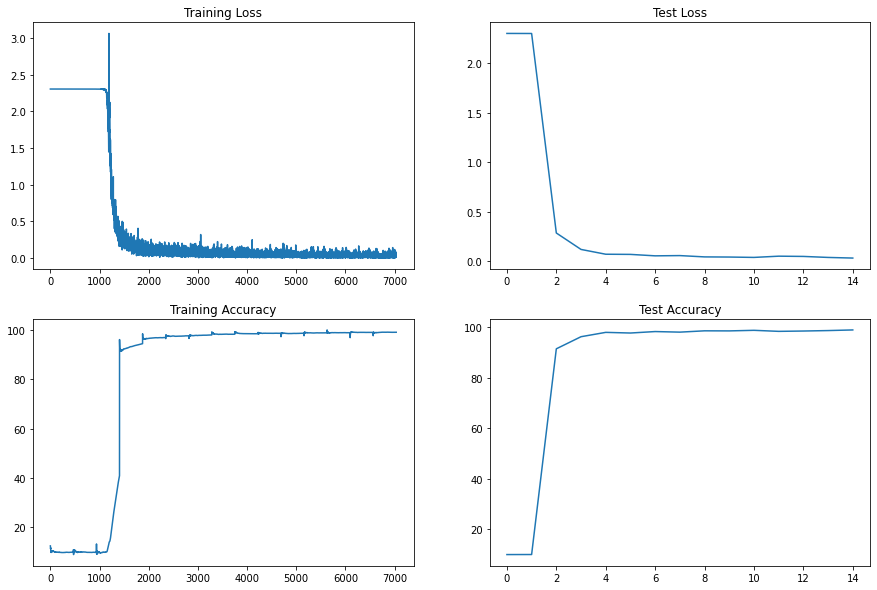

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

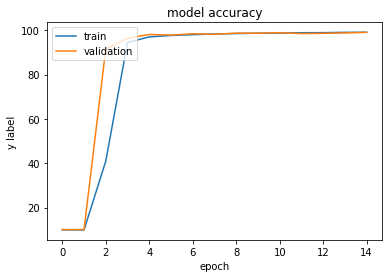

Best Train Accuracy: 99.06%
Best Test Accuracy: 99.01%


In [ ]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('y label')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print('Best Train Accuracy: {:.2f}%'.format(max(train_epoch_end[:])))
print('Best Test Accuracy: {:.2f}%'.format(max(test_acc[:])))

# Model 2
### Objective

* Reduce the number of parameters
* Achieve 99% Test accuracy with <15 Epochs

### Summary
* Model is working as expected
* Parameters: 13k
* Train Accuracy: 99.06%
* Test Accuracy: 99.01%
* No over fitting observed in the model
* Model can be pushed further to reduce the number to parameters and improve accuracy
* Add BatchNorm to help the model learn faster (Lower the number of epochs)



